In [31]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

In [32]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

def save_traces_to_zstd(traces, output_path, dtype=np.float32, trace_shape=(1, 54, 32768), compression_level=15):
    """
    Save a list of numpy arrays (traces) into a compressed Zstandard (.zst) file.
    """
    def shuffle_bytes(arr: np.ndarray) -> bytes:
        return arr.view(np.uint8).reshape(-1, arr.itemsize).T.tobytes()

    all_data = bytearray()
    for trace in traces:
        if trace.shape != trace_shape:
            raise ValueError(f"Trace has wrong shape {trace.shape}, expected {trace_shape}")
        shuffled = shuffle_bytes(trace.astype(dtype))
        all_data.extend(shuffled)

    compressor = zstd.ZstdCompressor(level=compression_level)
    compressed_data = compressor.compress(bytes(all_data))

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        f.write(compressed_data)

def load_traces_from_zstd(input_path, n_traces, dtype=np.float32, trace_shape=(1, 54, 32768)) -> np.ndarray:
    """
    Load a list of numpy arrays (traces) from a compressed Zstandard (.zst) file and return a single stacked ndarray.
    """
    def unshuffle_bytes(data: bytes, dtype=np.float32, shape=(1, 54, 32768)) -> np.ndarray:
        itemsize = np.dtype(dtype).itemsize
        num_elements = np.prod(shape)
        reshaped = np.frombuffer(data, dtype=np.uint8).reshape(itemsize, num_elements).T
        unshuffled = reshaped.reshape(-1)
        return unshuffled.view(dtype).reshape(shape)

    decompressor = zstd.ZstdDecompressor()
    with open(input_path, 'rb') as f:
        compressed_content = f.read()
        decompressed = decompressor.decompress(compressed_content)

    trace_size_bytes = np.prod(trace_shape) * np.dtype(dtype).itemsize
    expected_size = n_traces * trace_size_bytes
    if len(decompressed) != expected_size:
        raise ValueError("Decompressed size does not match expected size")

    traces = []
    for i in range(n_traces):
        start = i * trace_size_bytes
        end = start + trace_size_bytes
        trace_bytes = decompressed[start:end]
        trace = unshuffle_bytes(trace_bytes, dtype=dtype, shape=trace_shape)
        traces.append(trace)

    return np.stack(traces)

# Example usage (replace with actual TraceSimulator)
# ts = TraceSimulator(read_yaml_to_dict("config.yaml"))
# energy = 50
# n_sets = 100
# all_traces = []
# for _ in range(n_sets):
#     trace, _ = ts.generate(energy, type_recoil='NR', no_noise=False)
#     all_traces.append(np.asarray(trace, dtype=np.float16))
#
# save_traces_to_zstd(all_traces, f"compressed_traces/traces_energy_{energy}.zst")
# loaded_traces = load_traces_from_zstd(f"compressed_traces/traces_energy_{energy}.zst", n_traces=n_sets)



--- Trace Set 0 ---


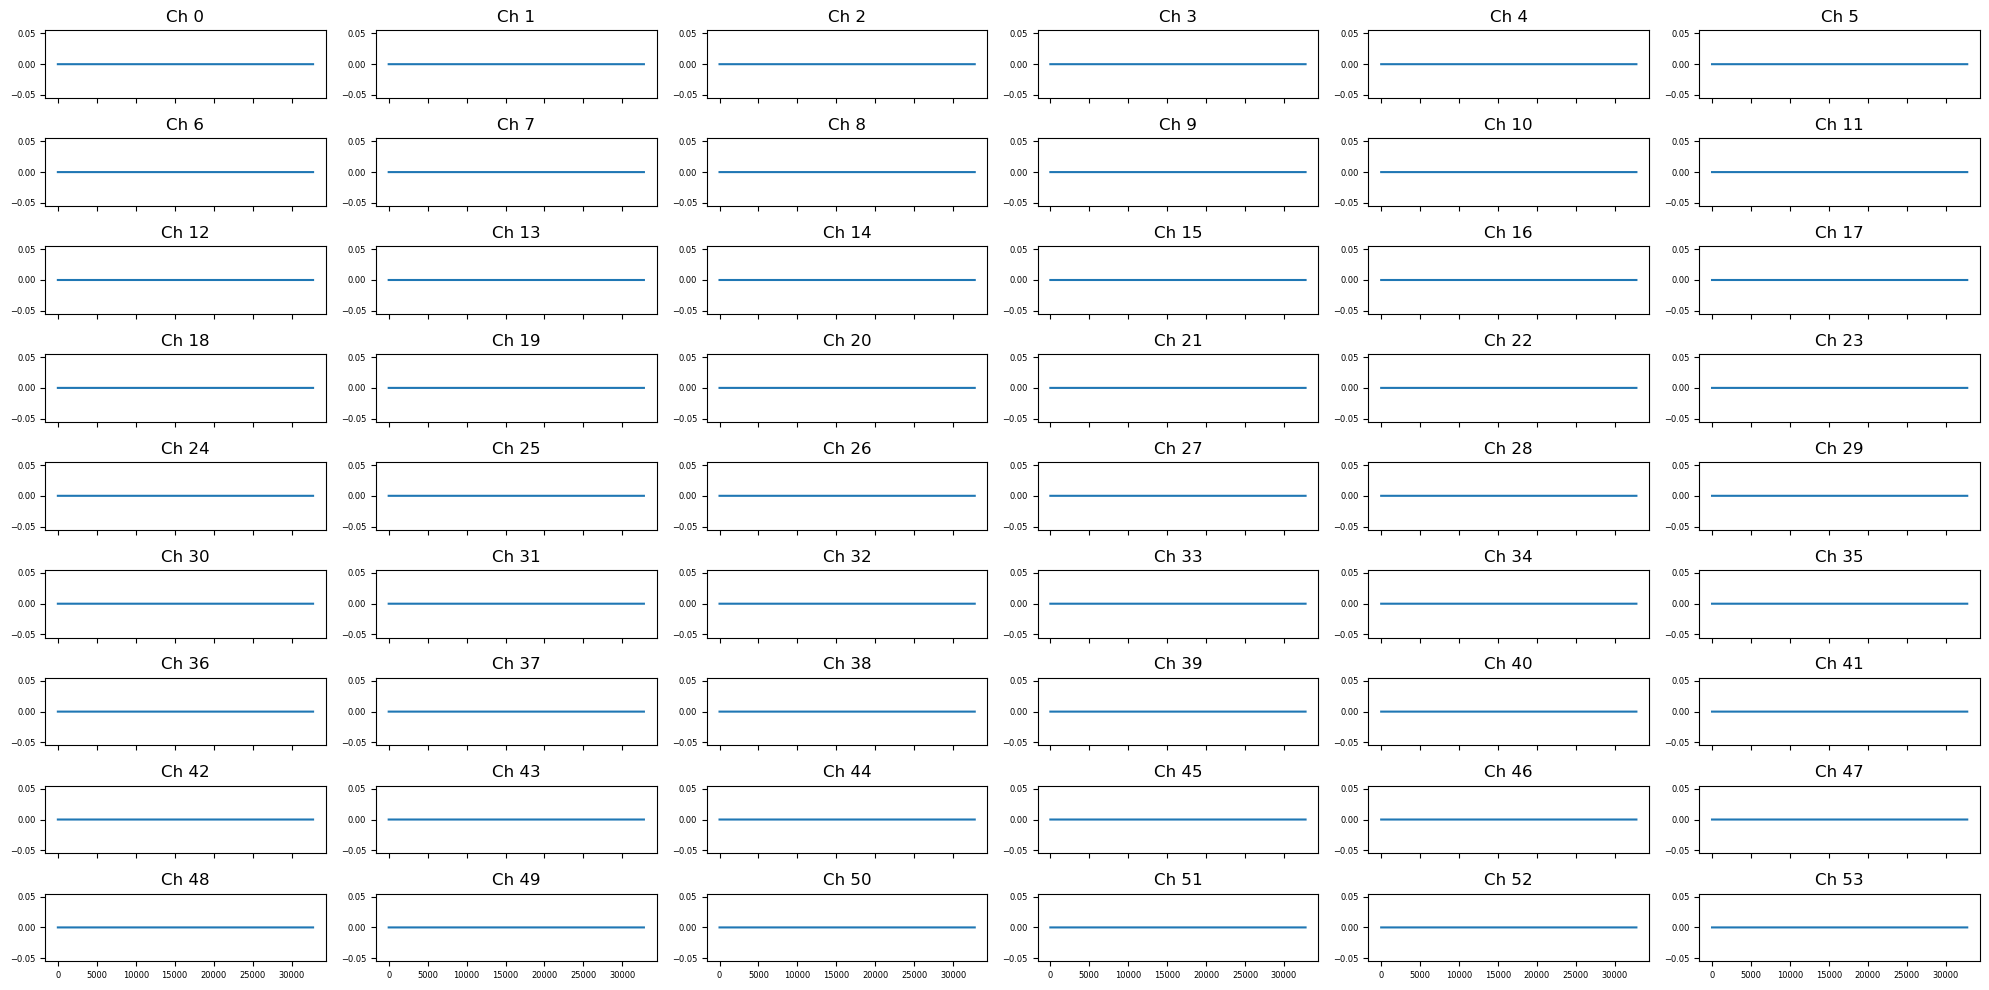


--- Trace Set 1 ---


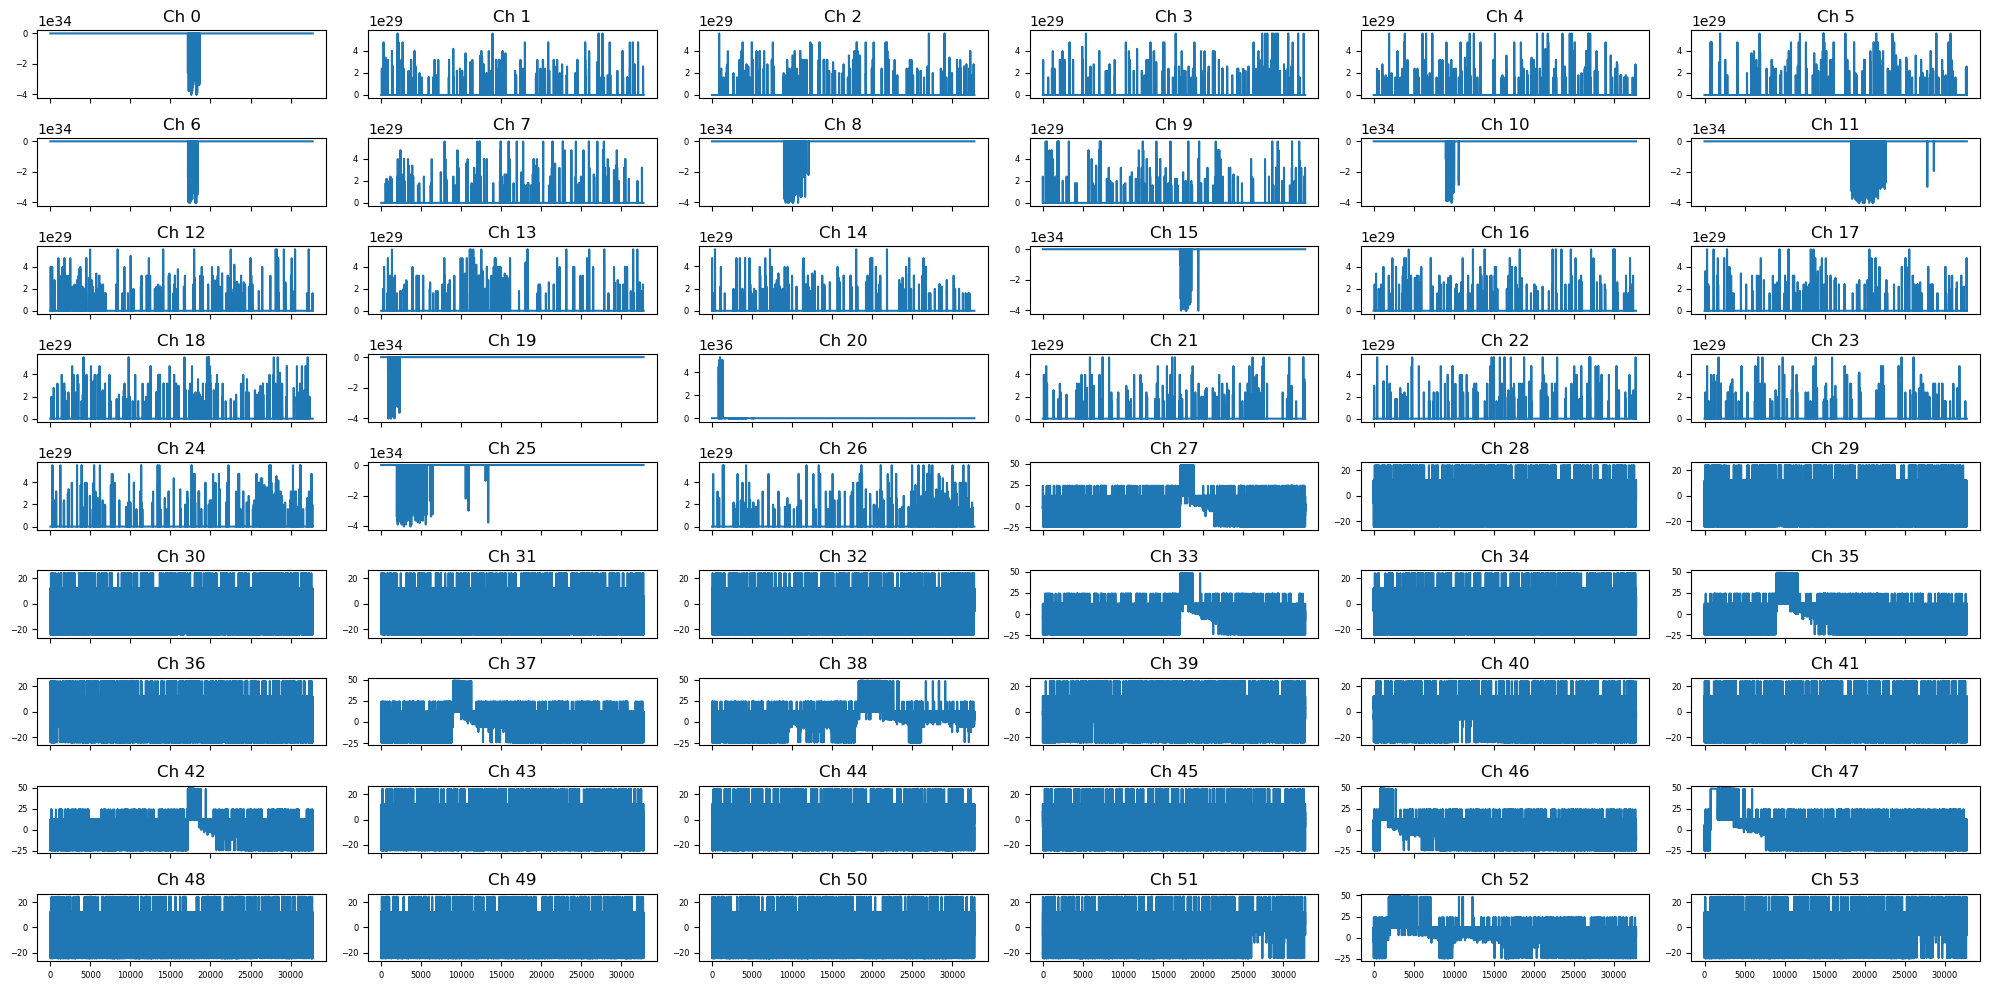

/home/dwong/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [ ]:
n_trace_sets = loaded_traces.shape[0]  # should be 2
n_channels = loaded_traces.shape[1]    # should be 54

channel_means = np.zeros((n_trace_sets, n_channels), dtype=np.float32)
channel_stds = np.zeros((n_trace_sets, n_channels), dtype=np.float32)

for i in range(n_trace_sets):
    trace_set = loaded_traces[i][0]  # shape: (54, 32768)

    print(f"\n--- Trace Set {i} ---")
    plot_trace_set(trace_set)  # optional visualization

    means = trace_set.mean(axis=1)  # (54,)
    stds = trace_set.std(axis=1)   # (54,)
    


In [ ]:
loaded_traces.shape

(2, 1, 54, 32768)

In [17]:
loaded_traces[1][0].shape

(54, 32768)

In [12]:
np.mean(loaded_traces[1][0][0])

0.27468872

In [13]:
np.std(loaded_traces[1][0][0])

5.3765965